In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

2024-05-08 21:26:05.853315: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-08 21:26:05.873488: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-08 21:26:05.873504: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-08 21:26:05.874051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-08 21:26:05.877550: I tensorflow/core/platform/cpu_feature_guar

### 1. Carga de datos

In [2]:
def load_data(filepath):
    return pd.read_csv(filepath, parse_dates=['Date'])

### 2. Division y tratamiento de datos

In [3]:
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps)])
        y.append(target[i + n_steps])
    return np.array(X), np.array(y)

In [4]:
def modify_data(data):
    result = None
    # print(data)

    # copy LMCADY_acu_5d_log into a new column ACU_5D and shift it by 5 days
    data['ACU_5D'] = data['LMCADY_acu_5d_log']
    data['ACU_5D'] = data['ACU_5D'].shift(5)

    data.dropna(inplace=True)

    result = data
    # print(result.head(10))
    return result

In [5]:
def prepare_data(df, target_column, n_steps):

    df = modify_data(df)


    features = df.drop(columns=[target_column, 'LMCADY_std_5d_log'])
    features = features.drop(columns = ['Date'])

    # print features being used
    print("Features utilizados:",features.columns)

    target = df[target_column]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X, y = create_sequences(features_scaled, target, n_steps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False)

    return X_train, X_test, y_train, y_test

In [6]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# # print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
# n_steps = 10
# # Preparación de los datos
# X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

### 3. Arquitectura y compilacion

In [7]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [8]:
def build_model(input_shape, md_prm: dict):
    model = Sequential([
        Conv1D(filters=md_prm['filters']*2, kernel_size=md_prm['kernel_size'], activation=md_prm['activation'], input_shape=input_shape),
        Conv1D(filters=md_prm['filters'], kernel_size=md_prm['kernel_size'], activation=md_prm['activation']),
        MaxPooling1D(pool_size=md_prm['pool_size']),
        Dropout(md_prm['dropout']/2),
        Flatten(),
        Dense(md_prm['dense_units']*2, activation=md_prm['dense_activation']),
        Dense(md_prm['dense_units'], activation=md_prm['dense_activation']),
        Dense(1, activation = "linear")
    ])
    # puede ser 0.0005
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[rmse])
    return model

### 4. Entrenamiento del modelo

In [9]:
def train_model(model, X_train, y_train, epochs, batch_size, verbose):
    early_stopping = EarlyStopping(
        monitor             ='val_rmse',
        patience            =10,
        verbose             =1,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, y_train,
        epochs          =epochs,
        batch_size      =batch_size,
        verbose         =verbose,
        validation_split=0.1,
        callbacks       =[early_stopping]
    )
    return history

### 5. Evaluacion de resultado

In [10]:
def evaluate_model(model, X_test, y_test):
    loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')

In [11]:
def plot_history(history):
    # plotear loss de entrenamiento y validación
    figsize = (8,2)

    plt.figure(figsize=figsize)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    # otras metricas
    for key in history.history.keys():
        if key not in ['loss', 'val_loss', 'val_rmse']:
            plt.figure(figsize=figsize)
            plt.plot(history.history[key], label=f'Training {key}')
            plt.plot(history.history[f'val_{key}'], label=f'Validation {key}')
            plt.title(f'Model {key.capitalize()}')
            plt.ylabel(key.capitalize())
            plt.xlabel('Epoch')
            plt.legend()
            plt.grid(True)
            plt.show()

In [12]:
def plot_predictions(y_true, y_pred, n, title="Prediction vs Actual Data"):
    # Asegurarse de que n no sea mayor que el número de puntos disponibles
    n = min(n, len(y_true), len(y_pred))

    # Usar slicing para obtener los últimos n valores
    y_true = y_true[-n:]
    y_pred = y_pred[-n:]

    plt.figure(figsize=(12, 2))
    plt.plot(y_true, label='Actual Values', marker='o', linestyle='-')
    plt.plot(y_pred, label='Predicted Values', marker='x', linestyle='--')

    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [13]:
# df = load_data("./input/copper_log_returns_5d_final.csv")
# n_steps = 25
# target_column = 'LMCADY_acu_5d_log'
# X_train, X_test, y_train, y_test = prepare_data(df, target_column, n_steps)
# y_test.std()
# model = build_model(X_train.shape[1:])
# history = train_model(model, X_train, y_train, epochs=100, batch_size=16)
# evaluate_model(model, X_test, y_test)

In [14]:
# n_steps_options     = [25, 50, 100, 150, 200]
# batch_size_options  = [32, 64, 128, 256]
n_steps_options = [10, 20, 30, 50]
batch_size_options = [8, 16, 32]
# n_steps_options     = [15]
# batch_size_options  = [16]
epochs_options      = [100]

filters_options         = [64, 128]
kernel_size_options     = [2, 3, 5]
pool_size_options       = [1, 2]
dense_units_options     = [50, 100]
# dense_activation_options = ['relu', 'tanh']
dense_activation_options = ['relu']
# activation_options      = ['relu', 'tanh']
activation_options      = ['relu']
dropout_options         = [0.1, 0.2]


model_params_combinations = list(itertools.product(
    filters_options, kernel_size_options, pool_size_options, dense_units_options,
    dense_activation_options, activation_options, dropout_options
))
target_column = 'LMCADY_acu_5d_log'

In [15]:
# number of iterations
n_iter = len(n_steps_options) * len(batch_size_options) * len(epochs_options) * len(model_params_combinations)
print(f'Total iterations: {n_iter}')

Total iterations: 576


In [16]:
def run_model_iterations():
    top_results = []

    i = 1
    for n_steps, batch_size, epochs, (filters, kernel_size, pool_size, dense_units, dense_activation, activation, dropout) in itertools.product(n_steps_options, batch_size_options, epochs_options, model_params_combinations):
        try:
            # Carga de datos
            df = load_data("./input/copper_log_returns_5d_final.csv")
            print(f"\n{i}) Testing with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")

            # Preparación de los datos
            X_train, X_test, y_train, y_test = prepare_data(df, 'LMCADY_acu_5d_log', n_steps)

            # print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

            # show a sample of X_train
            # print(f"X_train[1]: {X_train[1]}")
            # print("X_train[1] shape: ", X_train[1].shape)
            # print("X_train[2]: ", X_train[2])
            # print("X_train[2] shape: ", X_train[2].shape)
            # print("X_train",X_train)
            # print("X_train shape: ", X_train.shape)

            # Configuración de parámetros del modelo
            model_params = {
                'filters'           : filters,
                'kernel_size'       : kernel_size,
                'pool_size'         : pool_size,
                'dense_units'       : dense_units,
                'dense_activation'  : dense_activation,
                'activation'        : activation,
                'dropout'           : dropout
            }

            # Construcción y entrenamiento del modelo
            model   = build_model(X_train.shape[1:], model_params)
            print(model.summary())
            history = train_model(model, X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluación del modelo
            y_pred  = model.predict(X_test)
            # y_pred *= -1
            rmse_ob = sqrt(mean_squared_error(y_test, y_pred))
            std_dev = y_test.std()

            # diferencia entre rmse y desvstd
            difference = rmse_ob - std_dev

            # Guardar y ordenar resultados basados en la diferencia absoluta
            result = {
                'difference': difference,
                'rmse'      : rmse_ob,
                'std_dev'   : std_dev,
                'params'    : model_params,
                'history'   : history,
                'batch_size': batch_size,
                'n_steps'   : n_steps,
                'predictions': y_pred,
                'actuals'   : y_test
            }
            top_results.append(result)
            top_results = sorted(top_results, key=lambda x: x['difference'])[:10]

            print(f"\n{i}) RMSE: {rmse_ob:.6f}, Std Dev: {std_dev:.6f}, Difference: {difference:.6f}")
            print(f"Tested with n_steps={n_steps}, batch_size={batch_size}, epochs={epochs}, filters={filters}")
            print(f"Model params: {model_params}")

        except Exception as e:
            print(f"An error occurred: {e}. Skipping this combination.")
        i += 1

    return top_results

In [17]:
top_3_results = run_model_iterations()


1) Testing with n_steps=10, batch_size=8, epochs=100, filters=64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 128)            2432      
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 64)             16448     
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 64)             0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 64)             0         
                                                                 
 flatten (Flatten)           (None, 512)              

2024-05-08 21:26:06.919062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 21:26:06.937903: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 21:26:06.938018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

None


2024-05-08 21:26:09.094066: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-05-08 21:26:09.574866: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 21:26:09.740283: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-08 21:26:10.404216: I external/local_xla/xla/service/service.cc:168] XLA service 0x7aa59c00f400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 21:26:10.404231: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-08 21:26:10.407390: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1715221570.461148  364219 device_compiler.

Restoring model weights from the end of the best epoch: 16.
Epoch 26: early stopping
Epoch 26: early stopping
26/26 [==============================] - 1s 13ms/step

1) RMSE: 0.018418, Std Dev: 0.030739, Difference: -0.012322
Tested with n_steps=10, batch_size=8, epochs=100, filters=64
Model params: {'filters': 64, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}

2) Testing with n_steps=10, batch_size=8, epochs=100, filters=64
Features utilizados: Index(['LMCADS03', 'LMCADY', 'DXY', 'SPX', 'BCOM', 'MXWD', 'XAU', 'XAG',
       'ACU_5D'],
      dtype='object')
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 9, 128)            2432      
                                                                 
 conv1d_3 (Conv1D)           (None, 8, 64)             16448     
             


Top 1 Model
Best RMSE: 0.016102 vs. a std of 0.030736, diff = -0.014633
Model parameters: {'filters': 128, 'kernel_size': 3, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 30, batch_size: 16


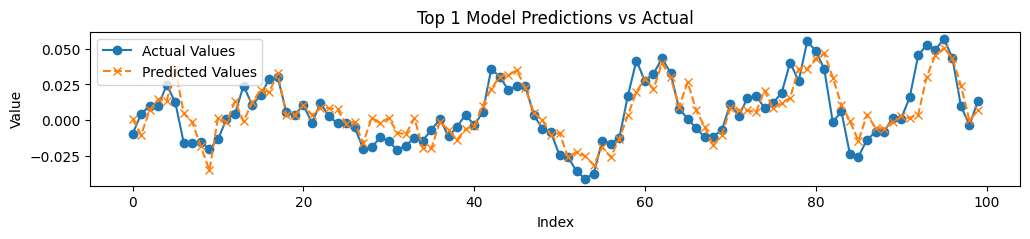


Top 2 Model
Best RMSE: 0.016160 vs. a std of 0.030736, diff = -0.014576
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 30, batch_size: 16


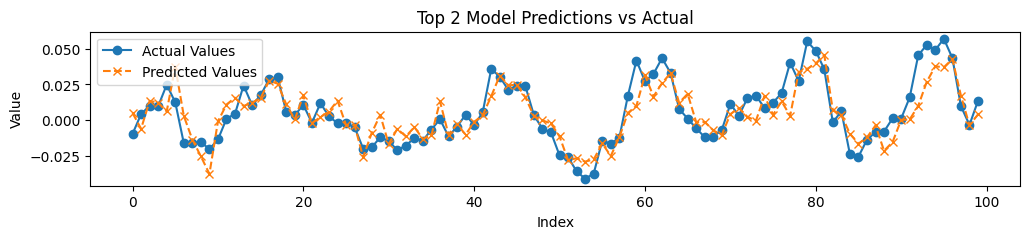


Top 3 Model
Best RMSE: 0.016220 vs. a std of 0.030739, diff = -0.014519
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 10, batch_size: 8


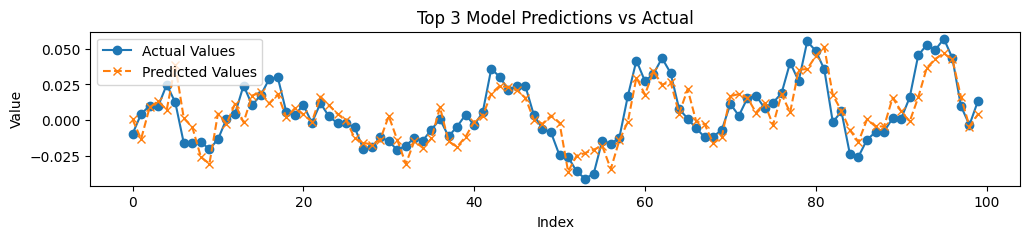


Top 4 Model
Best RMSE: 0.016237 vs. a std of 0.030739, diff = -0.014503
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 10, batch_size: 16


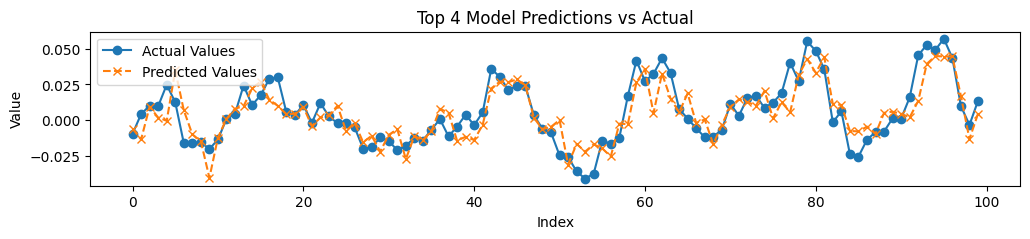


Top 5 Model
Best RMSE: 0.016214 vs. a std of 0.030616, diff = -0.014402
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 50, batch_size: 16


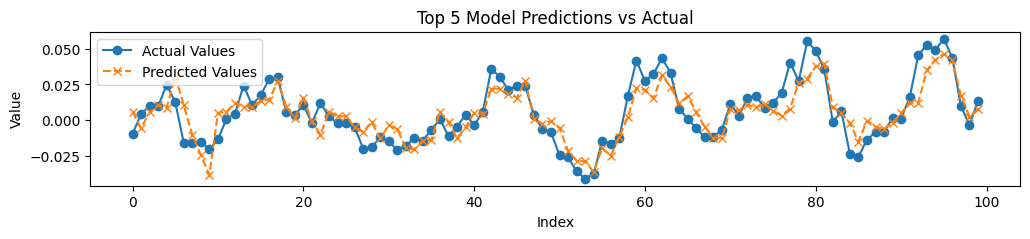


Top 6 Model
Best RMSE: 0.016352 vs. a std of 0.030739, diff = -0.014387
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 10, batch_size: 8


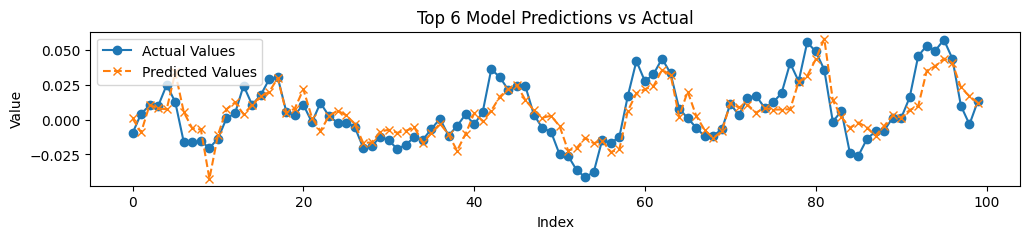


Top 7 Model
Best RMSE: 0.016377 vs. a std of 0.030739, diff = -0.014362
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 2, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 10, batch_size: 8


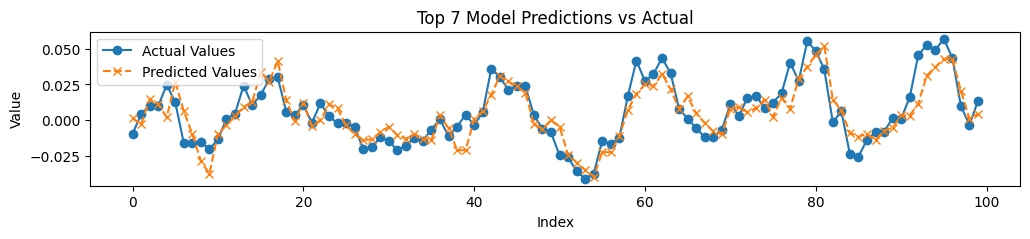


Top 8 Model
Best RMSE: 0.016432 vs. a std of 0.030758, diff = -0.014325
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 100, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 20, batch_size: 16


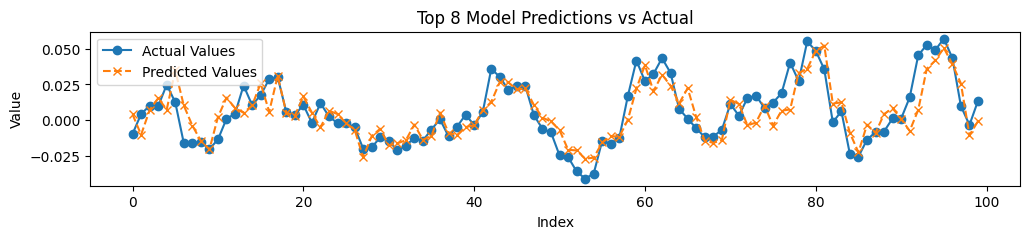


Top 9 Model
Best RMSE: 0.016418 vs. a std of 0.030736, diff = -0.014318
Model parameters: {'filters': 128, 'kernel_size': 3, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.1}
n_steps: 30, batch_size: 8


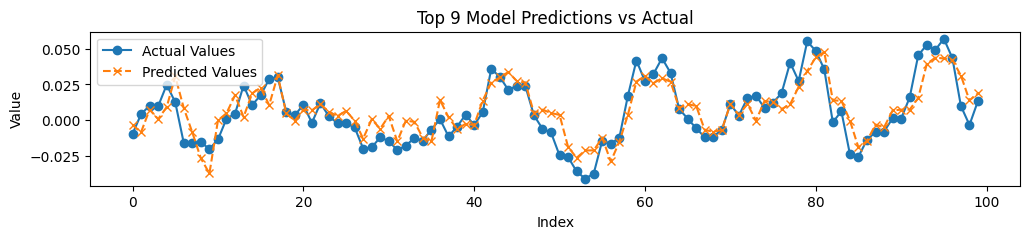


Top 10 Model
Best RMSE: 0.016423 vs. a std of 0.030736, diff = -0.014313
Model parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 1, 'dense_units': 50, 'dense_activation': 'relu', 'activation': 'relu', 'dropout': 0.2}
n_steps: 30, batch_size: 16


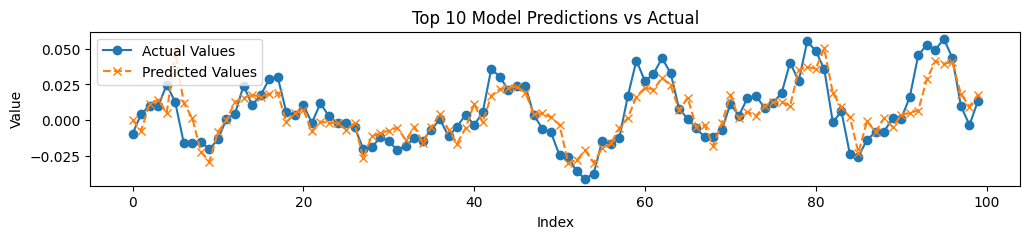

In [18]:
for i, result in enumerate(top_3_results, 1):
    rmse            = result['rmse']
    model_params    = result['params']
    history         = result['history']
    batch_size      = result['batch_size']
    n_steps         = result['n_steps']
    y_test          = result['actuals']
    y_pred          = result['predictions']
    diff = result['difference']

    print(f"\nTop {i} Model")
    print(f"Best RMSE: {rmse:.6f} vs. a std of {y_test.std():.6f}, diff = {diff:.6f}")
    print(f"Model parameters: {model_params}")
    print(f"n_steps: {n_steps}, batch_size: {batch_size}")

    # plot_history(history)

    plot_predictions(y_test, y_pred, 100, title=f"Top {i} Model Predictions vs Actual")
    # plot_predictions(y_test, y_pred*-1, 100, title=f"Top {i} Model Predictions vs Actual")

    # print the values of predictions and actuals one next to the other(only the first 10)
    # for pred, actual in zip(y_pred[:10], y_test[:10]):
    #     print(f"Predicted: {pred[0]:.6f}, Actual: {actual:.6f}")


In [19]:
"""
n_steps_options     = [15]
batch_size_options  = [16]
epochs_options      = [100]

filters_options         = [64, 128, 256]
kernel_size_options     = [2, 3, 5]
pool_size_options       = [1, 2]
dense_units_options     = [50, 100, 150]
# dense_activation_options = ['relu', 'tanh']
dense_activation_options = ['relu']
# activation_options      = ['relu', 'tanh']
activation_options      = ['relu']
dropout_options         = [0.1, 0.2, 0.3]
"""

"\nn_steps_options     = [15]\nbatch_size_options  = [16]\nepochs_options      = [100]\n\nfilters_options         = [64, 128, 256]\nkernel_size_options     = [2, 3, 5]\npool_size_options       = [1, 2]\ndense_units_options     = [50, 100, 150]\n# dense_activation_options = ['relu', 'tanh']\ndense_activation_options = ['relu']\n# activation_options      = ['relu', 'tanh']\nactivation_options      = ['relu']\ndropout_options         = [0.1, 0.2, 0.3]\n"